In [13]:
!code README.md

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

from env import get_db_url

from importlib import reload

In [14]:
def acquire_zillow():
    '''
    acuires data from codeup data base
    returns a pandas dataframe with
    'Single Family Residential' properties of 2017
    from zillow
    '''
    
    filename = 'zillow.csv'
    sql = '''
    SELECT bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, \
        fips, lotsizesquarefeet, poolcnt, \
        yearbuilt, taxvaluedollarcnt
    FROM properties_2017
    JOIN predictions_2017 USING(parcelid)
    JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE propertylandusedesc='Single Family Residential' AND transactiondate LIKE '2017%%'
    '''

    url = get_db_url('zillow')
    
    # if csv file is available locally, read data from it
    if os.path.isfile(filename):
        df = pd.read_csv(filename) 
    
    # if *.csv file is not available locally, acquire data from SQL database
    # and write it as *.csv for future use
    else:
        # read the SQL query into a dataframe
        df =  pd.read_sql(sql, url)
        
        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename, index_label = False)
        
    return df

In [18]:
df = acquire_zillow()

In [182]:
df.shape

(52441, 8)

##### The original data set contains 52,441 values. We can remove max 5% of data. The min number of data can be 49,819

In [183]:
52441 * .95

49818.95

In [92]:
52441 - 52441 * .95

2622.050000000003

In [32]:
df.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,lotsizesquarefeet,poolcnt,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,1.0,2.0,964.0,6037.0,1.0,7484.0,NaN,96125.0,0.0,1.0,1941.0,53793.0


In [101]:
df.isnull().sum()

bathrooms          0
bedrooms           0
sq_feet           82
fips               0
fullbathcnt      137
lot_sqfeet       369
pools          41345
year_built       116
home_value         1
dtype: int64

In [27]:
def rename_columns(df):
        df.rename(columns={
        'bedroomcnt':'bedrooms',
        'bathroomcnt':'bathrooms',
        'calculatedfinishedsquarefeet':'sq_feet',
        'taxvaluedollarcnt':'home_value',
        'yearbuilt':'year_built',
        'lotsizesquarefeet':'lot_sqft',
        'poolcnt':'pools',
    }, inplace=True)

In [20]:
rename_columns()

In [21]:
df.head(1)

,bathrooms,bedrooms,sq_feet,fips,lot_sqft,pools,year_built,home_value
0,2.0,3.0,1907.0,6059.0,8592.0,NaN,1959.0,893699.0


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   52441 non-null  float64
 1   bedrooms    52441 non-null  uint8  
 2   sq_feet     52359 non-null  float64
 3   fips        52441 non-null  float64
 4   lot_sqft    52441 non-null  float64
 5   pools       52441 non-null  float64
 6   year_built  52325 non-null  float64
 7   home_value  52440 non-null  float64
dtypes: float64(7), uint8(1)
memory usage: 3.3 MB


In [186]:
df['pools'] = df.pools.replace({np.NAN:0})

In [187]:
df['lot_sqft'] = df.lot_sqft.replace({np.NAN:0})

In [201]:
df.loc[:, 'bedrooms'].values

array([3., 3., 3., ..., 3., 3., 6.])

In [202]:
df.loc[:, 'bedrooms'] = df.loc[:, 'bedrooms'].values.astype('uint8', copy=False)

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   52441 non-null  float64
 1   bedrooms    52441 non-null  uint8  
 2   sq_feet     52359 non-null  float64
 3   fips        52441 non-null  float64
 4   lot_sqft    52072 non-null  float64
 5   pools       11096 non-null  float64
 6   year_built  52325 non-null  float64
 7   home_value  52440 non-null  float64
dtypes: float64(7), uint8(1)
memory usage: 3.3 MB


In [165]:
df.isnull().sum()

bathrooms       0
bedrooms        0
sq_feet        82
fips            0
lot_sqft        0
pools           0
year_built    116
home_value      1
dtype: int64

In [166]:
df = df.dropna(axis = 0) # 122 values removed

In [167]:
df.shape

(52319, 8)

In [137]:
52441 - 52319

122

In [178]:
df.pools.value_counts()

1.0    11096
Name: pools, dtype: int64

In [169]:
df.bathrooms.value_counts()

2.0     21888
3.0     10666
1.0      9553
2.5      3931
4.0      2227
3.5       913
1.5       840
5.0       803
4.5       682
6.0       322
5.5       224
7.0        88
8.0        53
6.5        47
0.0        41
7.5        16
9.0        13
10.0        5
11.0        3
8.5         2
18.0        1
13.0        1
Name: bathrooms, dtype: int64

In [173]:
df.bathrooms.value_counts()

2     25819
3     11579
1     10393
4      2909
5      1027
6       369
7       104
8        55
0        41
9        13
10        5
11        3
18        1
13        1
Name: bathrooms, dtype: int64

In [130]:
(df.lot_sqfeet == 0).sum()

0

In [172]:
df.loc[:, 'bathrooms'] = df.loc[:, 'bathrooms'].astype('uint8')

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   52319 non-null  float64
 1   bedrooms    52319 non-null  float64
 2   sq_feet     52319 non-null  float64
 3   fips        52319 non-null  float64
 4   lot_sqft    52319 non-null  float64
 5   pools       52319 non-null  float64
 6   year_built  52319 non-null  float64
 7   home_value  52319 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


In [174]:
df.loc['lot_sqft'] = df.loc[:, 'lot_sqft'].astype(int)

In [152]:
((df.bathrooms == 0) & (df.bedrooms == 0)).sum()

25

In [11]:
def transform_columns(df):
    # transform fips to integer
    df['fips'] = df.loc[:, 'fips'].astype(int)
    #remove null values   
    #df = df.dropna()

    # add a new column with county names
    df['county_name'] = np.select([(df.fips == 6037), (df.fips == 6059), (df.fips == 6111)],
                             ['LA', 'Orange', 'Ventura'])
    # column to category data type
    df['county_name'] = df.loc[:, 'county_name'].astype('category', copy=False)

    # replace NaN with 0 in the pools columns
    df['pools'] = df.pools.replace({np.NAN:0})
    
    # replace NaN with 0 in the lot_sqft. Needs to be imputed later
    df['lot_sqft'] = df.lot_sqft.replace({np.NAN:0})
    
    # drop null values
    df = df.dropna(axis=0)
    
    # create a column 'house_age'
    df['house_age'] = 2017 - df.year_built

    # change the type of bedrooms/sq_feet/home_value/pools to integer
    df['bedrooms'] = df.loc[:, 'bedrooms'].values.astype('uint8', copy=False)
    df['sq_feet'] = df.loc[:, 'sq_feet'].values.astype(int, copy=False)
    df['lot_sqft'] = df.loc[:, 'lot_sqft'].values.astype(int, copy=False)
    df['home_value'] = df.loc[:, 'home_value'].values.astype(int, copy=False)
    df['house_age'] = df.loc[:, 'house_age'].values.astype('uint8', copy=False)
    df['pools'] = df.loc[:, 'pools'].values.astype('uint8', copy=False)
    

    

    #rearange columns and drop 'fips'
    cols = ['bedrooms',
            'bathrooms',
            'sq_feet',
            'lot_sqft',
            'year_built',
            'house_age',
            'pools',
            'county_name',
            'home_value']
    
    df = df[cols]
    
    return df

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   bedrooms     52319 non-null  uint8   
 1   bathrooms    52319 non-null  float64 
 2   sq_feet      52319 non-null  int64   
 3   lot_sqft     52319 non-null  int64   
 4   year_built   52319 non-null  float64 
 5   house_age    52319 non-null  uint8   
 6   pools        52319 non-null  uint8   
 7   LA           52319 non-null  int64   
 8   Ventura      52319 non-null  int64   
 9   county_name  52319 non-null  category
 10  home_value   52319 non-null  int64   
dtypes: category(1), float64(2), int64(5), uint8(3)
memory usage: 3.4 MB


In [28]:
def get_zillow():
    df = acquire_zillow()
    rename_columns(df)
    df = transform_columns(df)
    return df

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   bedrooms     52319 non-null  uint8   
 1   bathrooms    52319 non-null  float64 
 2   sq_feet      52319 non-null  int64   
 3   lot_sqft     52319 non-null  int64   
 4   year_built   52319 non-null  float64 
 5   house_age    52319 non-null  uint8   
 6   pools        52319 non-null  uint8   
 7   LA           52319 non-null  int64   
 8   Ventura      52319 non-null  int64   
 9   county_name  52319 non-null  category
 10  home_value   52319 non-null  int64   
dtypes: category(1), float64(2), int64(5), uint8(3)
memory usage: 3.4 MB


In [31]:
def dummies(df):
    '''
    create dummy variables for LA and Ventura
    '''
    # create dummies for LA and Ventura
    df['LA'] = np.where(df.county_name == 'LA', 1, 0)
    df['Ventura'] = np.where(df.county_name == 'Ventura', 1, 0)

In [58]:
def handle_outliers(df):

    '''
    the function removes outliers from the data set
    '''

    # remove bathrooms below quantile 0.99
    q_bed = df.bedrooms.quantile(0.99)
    df = df[df.bedrooms < q_bed]

    # remove bedrooms below quantile 0.99
    q_bath = df.bathrooms.quantile(0.99)
    df = df[df.bathrooms < q_bath] 

    # remove lot_sqft below quantile 0.99
    q_lot = df.lot_sqft.quantile(0.99)
    df = df[df.lot_sqft < q_lot]

    return df

In [4]:
import wrangle

In [9]:
reload(wrangle)

<module 'wrangle' from '/Users/nadina/codeup-data-science/zillow-project/wrangle.py'>

In [10]:
df1 = wrangle.get_zillow()

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51959 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   bedrooms     51959 non-null  uint8   
 1   bathrooms    51959 non-null  uint8   
 2   sq_feet      51959 non-null  int64   
 3   lot_sqft     51959 non-null  int64   
 4   year_built   51959 non-null  int64   
 5   house_age    51959 non-null  uint8   
 6   pools        51959 non-null  uint8   
 7   county_name  51959 non-null  category
 8   home_value   51959 non-null  int64   
dtypes: category(1), int64(4), uint8(4)
memory usage: 2.2 MB


In [14]:
df1.head()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,county_name,home_value
0,3,2,1907,8592,1959,58,0,Orange,893699
1,3,2,1817,7485,1985,32,0,LA,174757
2,3,2,1801,7200,1965,52,0,Orange,660451
3,4,4,2954,2396,1924,93,0,LA,735227
4,4,2,1390,7000,1962,55,0,Orange,429900


In [15]:
pd.options.display.float_format = '{:,.3f}'.format

In [16]:
df1.describe()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,home_value
count,"51,959.000","51,959.000","51,959.000","51,959.000","51,959.000","51,959.000","51,959.000","51,959.000"
mean,3.305,2.233,"1,918.252","11,251.589","1,963.248",53.752,0.212,"525,552.312"
std,0.934,0.989,994.308,"86,640.636",22.976,22.976,0.409,"716,442.460"
min,0.000,0.000,128.000,236.000,"1,878.000",1.000,0.000,"1,000.000"
25%,3.000,2.000,"1,268.000","5,581.500","1,950.000",38.000,0.000,"193,482.500"
50%,3.000,2.000,"1,657.000","6,838.000","1,960.000",57.000,0.000,"372,791.000"
75%,4.000,3.000,"2,301.000","8,777.000","1,979.000",67.000,0.000,"616,741.500"
max,11.000,13.000,"21,929.000","6,971,010.000","2,016.000",139.000,1.000,"25,381,250.000"


In [17]:
df1 = wrangle.handle_outliers(df1)

In [18]:
df1.shape

(49996, 9)

In [19]:
df1.describe()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,home_value
count,"49,996.000","49,996.000","49,996.000","49,996.000","49,996.000","49,996.000","49,996.000","49,996.000"
mean,3.230,2.123,"1,812.761","10,665.493","1,962.621",54.379,0.197,"466,453.891"
std,0.846,0.795,776.890,"86,932.283",22.565,22.565,0.398,"477,632.392"
min,0.000,0.000,128.000,236.000,"1,878.000",1.000,0.000,"1,000.000"
25%,3.000,2.000,"1,254.000","5,520.000","1,950.000",39.000,0.000,"187,239.000"
50%,3.000,2.000,"1,624.000","6,754.000","1,960.000",57.000,0.000,"361,968.500"
75%,4.000,3.000,"2,202.000","8,501.000","1,978.000",67.000,0.000,"586,007.250"
max,5.000,4.000,"12,616.000","6,971,010.000","2,016.000",139.000,1.000,"13,600,098.000"


In [29]:
q_upper = df1.lot_sqft.quantile(0.75)
lot_observ = df1[df1.lot_sqft > 13110].sort_values(by='lot_sqft')

##### The amount of outliers in the ```lot_sqft``` is very high. We can not remove them! 

In [34]:
q = lot_observ.lot_sqft.quantile(0.99)
lot_observ[lot_observ.lot_sqft > q]

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,county_name,home_value
16654,2,2,3366,435675,1990,27,1,LA,776650
35531,3,2,2422,437874,2013,4,0,LA,324760
16342,2,2,1534,438504,1977,40,0,LA,126568
1085,1,1,745,443008,1942,75,0,LA,192000
9854,2,1,1100,443008,1942,75,0,LA,115000
5377,1,1,729,443008,1942,75,0,LA,219000
39281,1,1,1012,443008,1942,75,0,LA,255000
13091,2,2,1136,443008,1942,75,0,LA,143263
47921,2,1,999,445495,1957,60,0,LA,113300
14307,4,3,2167,460421,1984,33,0,LA,419420


In [87]:
df.describe()

,bedrooms,bathrooms,sq_feet,year_built,house_age,pools,home_value
count,"52,319.000","52,319.000","52,319.000","52,319.000","52,319.000","52,319.000","52,319.000"
mean,3.306,2.239,"1,922.554","1,963.395",53.605,0.212,"528,076.829"
std,0.941,0.998,"1,003.618",23.134,23.134,0.409,"748,460.452"
min,0.000,0.000,128.000,"1,878.000",1.000,0.000,"1,000.000"
25%,3.000,2.000,"1,268.000","1,950.000",38.000,0.000,"193,711.000"
50%,3.000,2.000,"1,658.000","1,961.000",56.000,0.000,"373,379.000"
75%,4.000,3.000,"2,305.000","1,979.000",67.000,0.000,"618,625.000"
max,14.000,18.000,"21,929.000","2,016.000",139.000,1.000,"49,061,236.000"


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

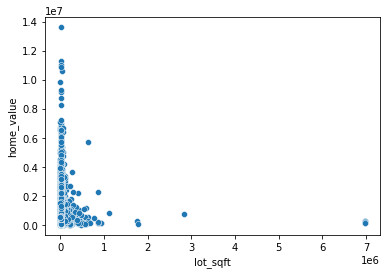

In [38]:
sns.scatterplot(data=df1, x='lot_sqft', y='home_value');

In [39]:
log_lot_sqft = np.log(df1.lot_sqft)

<AxesSubplot:xlabel='lot_sqft', ylabel='home_value'>

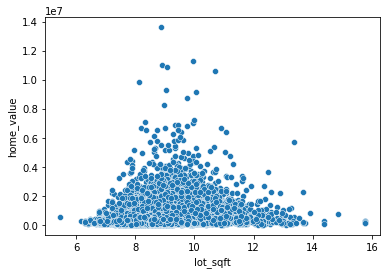

In [40]:
sns.scatterplot(x = log_lot_sqft, y = df1.home_value)

In [41]:
df1.head()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,county_name,home_value
0,3,2,1907,8592,1959,58,0,Orange,893699
1,3,2,1817,7485,1985,32,0,LA,174757
2,3,2,1801,7200,1965,52,0,Orange,660451
3,4,4,2954,2396,1924,93,0,LA,735227
4,4,2,1390,7000,1962,55,0,Orange,429900


In [43]:
(df1.drop_duplicates()).shape

(49866, 9)

In [46]:
df1.shape

(49996, 9)

In [47]:
49996 - 49866

130

In [48]:
df1.describe()

,bedrooms,bathrooms,sq_feet,lot_sqft,year_built,house_age,pools,home_value
count,"49,996.000","49,996.000","49,996.000","49,996.000","49,996.000","49,996.000","49,996.000","49,996.000"
mean,3.230,2.123,"1,812.761","10,665.493","1,962.621",54.379,0.197,"466,453.891"
std,0.846,0.795,776.890,"86,932.283",22.565,22.565,0.398,"477,632.392"
min,0.000,0.000,128.000,236.000,"1,878.000",1.000,0.000,"1,000.000"
25%,3.000,2.000,"1,254.000","5,520.000","1,950.000",39.000,0.000,"187,239.000"
50%,3.000,2.000,"1,624.000","6,754.000","1,960.000",57.000,0.000,"361,968.500"
75%,4.000,3.000,"2,202.000","8,501.000","1,978.000",67.000,0.000,"586,007.250"
max,5.000,4.000,"12,616.000","6,971,010.000","2,016.000",139.000,1.000,"13,600,098.000"
